In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import spyrit.misc.walsh_hadamard as wh
import sys

from spyrit.misc.statistics import stat_walsh_stl10
from spyrit.learning.model_Had_DCAN import Permutation_Matrix
from spyrit.misc.statistics import *
from spyrit.misc.disp import *

In [2]:
img_size = 64 # image size
M = 1024    # number of measurements
N0 = 10   # Image intensity (in photons)
bs = 5 # Batch size

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size


Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Hperm = Perm@H;
Pmat = Hperm[:M,:];

Cov_perm = Perm@Cov@Perm.T;


In [6]:
x = inputs.view(b*c,w*h)
x_0 = torch.zeros_like(x)

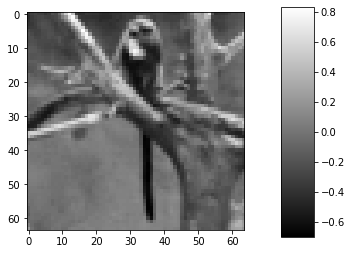

In [7]:
img = x[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

In [8]:
from spyrit.restructured.Updated_Had_Dcan import * 

In [9]:
FO_split = Split_Forward_operator(Pmat)
A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)
SPP = Split_diag_poisson_preprocess(N0, M, w*h)

In [10]:
m = A_b(x)
y = SPP(m,FO_split)
var = SPP.sigma(m)

# Pinv_orthogonal (validated)
## Instancier

In [11]:
P = Pinv_orthogonal()

## Test methode forward

In [12]:
x_est = P(y, FO_split)

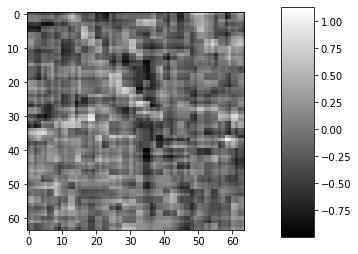

In [13]:
img = x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

# learned_measurement_to_image (Validated)
## Instantiation

In [14]:
P = learned_measurement_to_image(h*w, M)

## Test methode forward

In [15]:
x_est = P(y, FO_split)

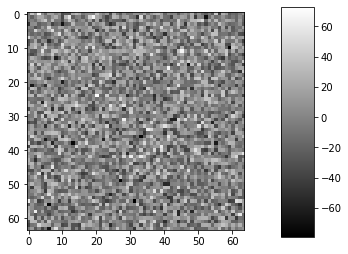

In [16]:
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

Makes sens that we don't see anything as it currently only has random weights

# gradient_step (validated)
gradient descent step of the function 
$$\|\mathbf{Ax}-b\|^2$$
## Instantiation

In [17]:
P = gradient_step(mu = 0.0003)

## Test methode forward

In [18]:
x_est = P(y, x_0, FO_split)

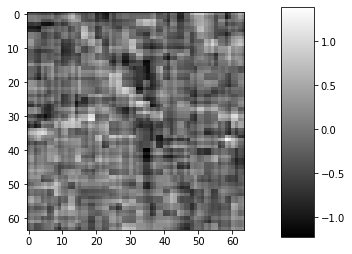

In [19]:
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

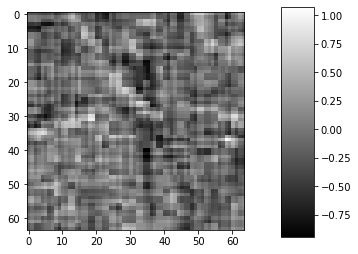

In [20]:
x_est = P(y, x_est, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

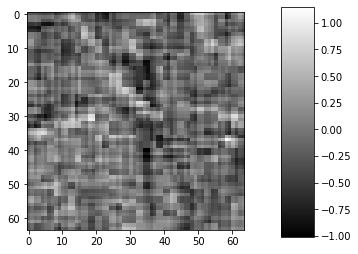

In [21]:
x_est = P(y, x_est, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

After 3 iterations we converge at the pseudo inverse (given the correct initial $\mu$

The solution to 
$$x^* = \text{argmin}_x \| Ax-b \|_{\Sigma^\alpha}^2 + \|x-x_0\|_{\Sigma}^2$$

The general solution is 
$$x^* = x_0 + \Sigma A^\top (A \Sigma A^\top + \Sigma^\alpha)^{-1}(b - Ax_0)$$
# Tikhonov_cg (Validated)
Case where $\Sigma = I$, $\Sigma^\alpha = \mu I$, for now we consider $x_0 = 0$, we get for Hadamard patterns
$$x^* = H^\top S^\top (S H H^\top S^\top + \mu I)^{-1}b$$
which gives 
$$x^* = H^\top S^\top (N I + \mu I)^{-1}b = H^\top S^\top \frac{1}{N+\mu}b$$
## Instantiation

In [22]:
P = Tikhonov_cg(n_iter = 6, mu = 1)

## Test methode forward

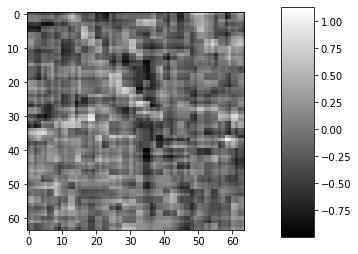

In [23]:
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

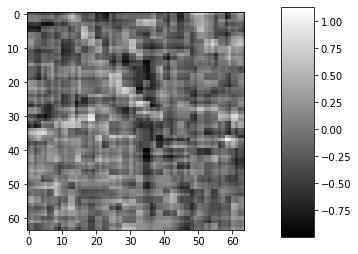

In [24]:
P = Tikhonov_cg(n_iter = 100, mu = 1)
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

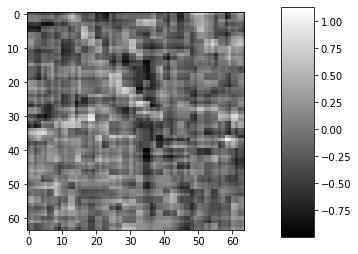

In [25]:
P = Tikhonov_cg(n_iter = 1, mu = 1)
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

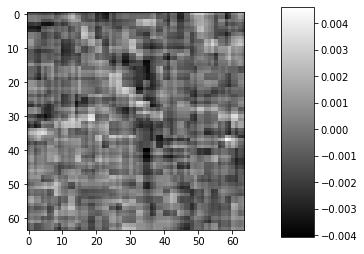

In [26]:
P = Tikhonov_cg(n_iter = 1, mu = 1000000)
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

Exactly what we can expect from Tikhonov regularisation.

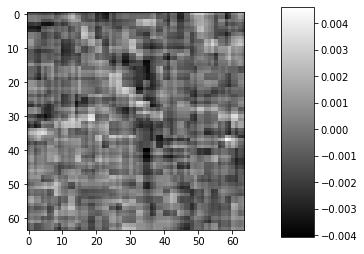

In [27]:
P = Tikhonov_cg(n_iter = 3, mu = 1000000)
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

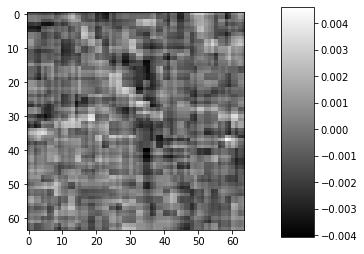

In [28]:
P = Tikhonov_cg(n_iter = 5, mu = 1000000)
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

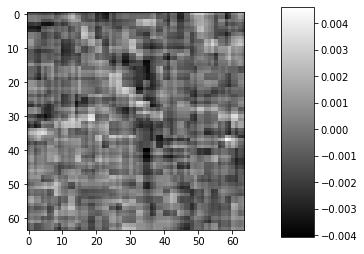

In [29]:
P = Tikhonov_cg(n_iter = 6, mu = 1000000)
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

# Tikhonov_solve (validated)
## Instantiation

In [30]:
P = Tikhonov_solve(mu = 0.1)

## Test methode forward

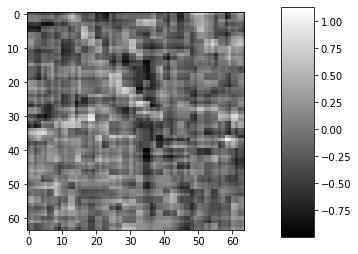

In [31]:
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

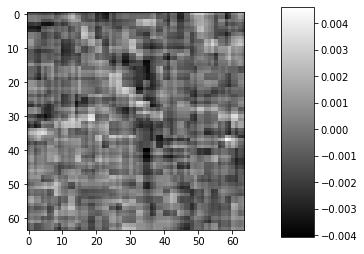

In [32]:
P = Tikhonov_solve(mu = 1000000)
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

Too much regularisation (makes sense) due to tikhonov formula

# Orthogonal Tikhonov (Validated)
## Instantiation

In [33]:
P = Orthogonal_Tikhonov(mu = 0.1)

## Test methode forward

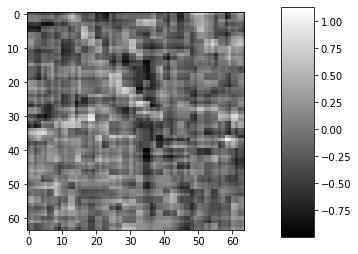

In [34]:
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

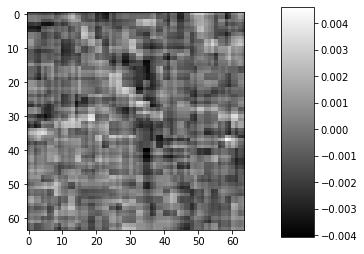

In [35]:
P = Orthogonal_Tikhonov(mu = 1000000)
x_est = P(y, x_0, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

Too much regularisation (makes sense) due to tikhonov formula

# Generalised_Tikhonov_cg (not yet validated)
General solution to any $\Sigma$ and $\Sigma^\alpha$
$$x^* = x_0 + \Sigma A^\top (A \Sigma A^\top + \Sigma^\alpha)^{-1}(b - Ax_0)$$


## Instantiation

In [36]:
Sigma_prior = (1/(h*w))**2*Hperm.T@Cov@Hperm;
P = Generalised_Tikhonov_cg(Sigma_prior = Sigma_prior, n_iter = 5)

## Test methode forward

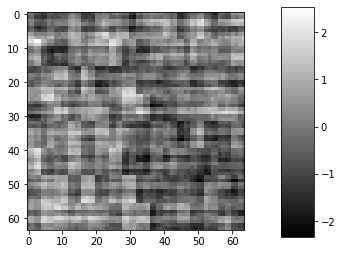

In [37]:
x_est = P(y, x_0, var, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

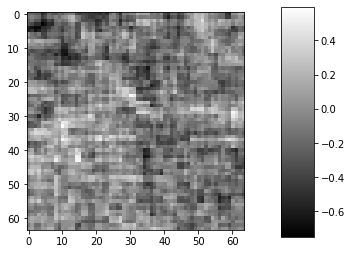

In [38]:
P = Generalised_Tikhonov_cg(Sigma_prior = Sigma_prior, n_iter = 50)
x_est = P(y, x_0, var, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

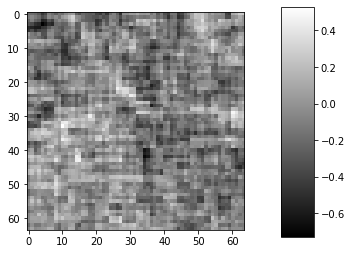

In [39]:
P = Generalised_Tikhonov_cg(Sigma_prior = Sigma_prior, n_iter = 100)
x_est = P(y, x_0, var, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

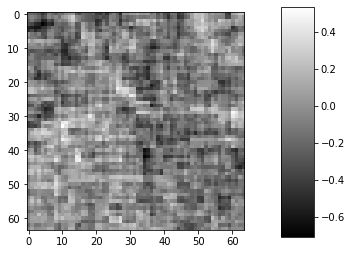

In [40]:
P = Generalised_Tikhonov_cg(Sigma_prior = Sigma_prior, n_iter = 150)
x_est = P(y, x_0, var, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

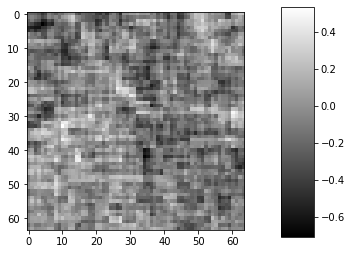

In [41]:
P = Generalised_Tikhonov_cg(Sigma_prior = Sigma_prior, n_iter = 200)
x_est = P(y, x_0, var, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

Convergence is a bit slower than expected(it takes around 100-150 iterations), but it seems to be working
For some reason ranges appear to be wrong... Need to debug? Or do I?

# Generalised_Tikhonov_solve (Not Validated - nearly there - Compare with previous methods)
$$x^* = x_0 + \Sigma A^\top (A \Sigma A^\top + \Sigma^\alpha)^{-1}(b - Ax_0)$$
when $A = SH$, and H is an orthogonal transform, and S is a downsampling matrix, then we get 
$$H^\top(x^* - x_0) = H^\top \Sigma H^\top S^\top (S H \Sigma H^\top S^\top + \Sigma^\alpha)^{-1}(b - Ax_0)$$
Noting $C = H \Sigma H^\top$, 
$$H^\top(x^* - x_0) = C S^\top (S C S^\top + \Sigma^\alpha)^{-1}(b - Ax_0)$$
If we note $C = \begin{bmatrix}C_1 & C_{21}^\top\\ C_{21} & C_2\end{bmatrix}$, 
the solution is 
$$y = H^\top(x^* - x_0) = \begin{bmatrix}C_1 \\ C_{21}\end{bmatrix} (C_1 + \Sigma^\alpha)^{-1}(b - Ax_0)$$
Which we can compute as 
$$y_1 = C_1(C_1 + \Sigma^\alpha)^{-1}(b - Ax_0)$$
$$y_2 = C_{21}(C_1 + \Sigma^\alpha)^{-1}(b - Ax_0) = C_{21}C_1^{-1}y_1$$
## Instantiation

In [42]:
# Sigma_prior = (1/(h*w))**2*Hperm.T@Cov@Hperm;
P = Generalised_Tikhonov_solve(Sigma_prior = Sigma_prior)

## Test methode forward

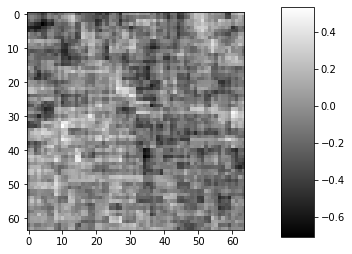

In [43]:
x_est = P(y, x_0, var, FO_split)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

# Generalized_Orthogonal_Tikhonov (Validated)
## Instantiation

In [44]:
FO_split_had = Split_Forward_operator_ft_had(Pmat, Perm)
P = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov_perm, M = M, N = h*w)

## Test methode forward

tensor([[0.9997, 0.9994, 0.9992,  ..., 0.4159, 0.4166, 0.4138],
        [0.9998, 0.9995, 0.9993,  ..., 0.4577, 0.4555, 0.4540],
        [0.9997, 0.9993, 0.9990,  ..., 0.3718, 0.3730, 0.3725],
        [0.9998, 0.9995, 0.9994,  ..., 0.4816, 0.4816, 0.4797],
        [0.9998, 0.9995, 0.9994,  ..., 0.4697, 0.4679, 0.4667]])


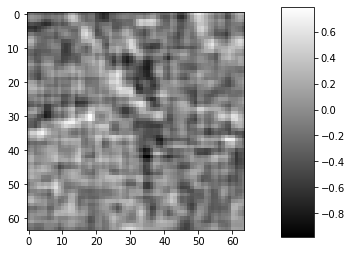

In [45]:
x_est = P(y, x_0, var, FO_split_had)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

The image looks like it should!

# List_Generalized_Orthogonal_Tikhonov (Validated)
## Instantiation

In [46]:
sigma_prior_list = [];
sigma_prior_list.append(Cov)
sigma_prior_list.append(1/100*Cov)
P = List_Generalized_Orthogonal_Tikhonov(sigma_prior_list = sigma_prior_list, M = M, N = h*w, n_comp = 2, n_denoi = 5)

## Test methode forward

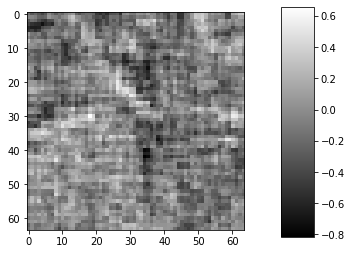

In [47]:
x_est = P(y, x_0, var, FO_split_had, 0)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

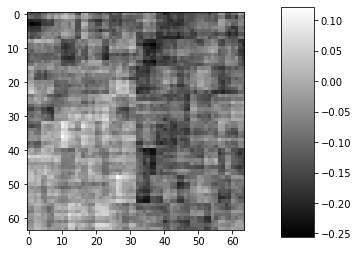

In [48]:
x_est = P(y, x_0, var, FO_split_had, 1)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

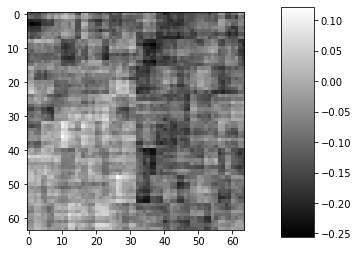

In [49]:
x_est = P(y, x_0, var, FO_split_had, 2)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

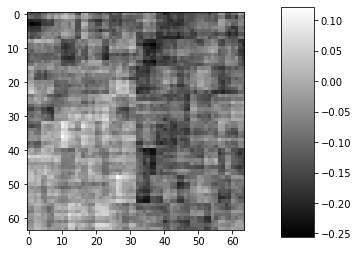

In [50]:
x_est = P(y, x_0, var, FO_split_had, 3)
img = x_est[1,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

The image looks like it should!

# Tikhonov_cg_pylops /!\ Aborded for now - problems with the  MatrixLinearOperator not being capable of taking Hermitian inverse + Multiplication
## Instantiation

In [51]:
# FO_pyl = Split_Forward_operator_pylops(Pmat)
# P = Tikhonov_cg_pylops(FO_pyl, n_iter = 6, mu = 1)

## Test methode forward

In [52]:
# x_est = P(y, x_0)
# img = x_est[1,:]
# img = img.detach().numpy();
# imagesc(np.reshape(img,(h,w)))

# Generalised_Tikhonov_cg_pylops /!\ Aborded for now - Pylops still under development 
## Instantiation

In [53]:
# FO_pyl = Split_Forward_operator_pylops(Pmat)
# P = Generalised_Tikhonov_cg_pylops(FO_pyl, n_iter = 6, mu = 1)

## Test methode forward

In [54]:
# x_est = P(y, x_0)
# img = x_est[1,:]
# img = img.detach().numpy();
# imagesc(np.reshape(img,(h,w)))